Part 1. Load the CrashStats Dataset

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Load the data from CSV files

road_type_data = pd.read_csv('accident_location.csv', usecols=['ACCIDENT_NO', 'ROAD_TYPE'])

crash_location_data = pd.read_csv('node.csv', usecols=['ACCIDENT_NO', 'Lat', 'Long', 'POSTCODE_NO'])

person_data = pd.read_csv('person.csv', usecols=['ACCIDENT_NO', 'SEX', 'AGE', 'SEATING_POSITION'])
person_data[['SEX', 'SEATING_POSITION']] = person_data[['SEX', 'SEATING_POSITION']].apply(lambda x: x.str.replace(' ', ''))
driver_information_data = person_data[person_data['SEATING_POSITION'] == 'D']

vehicle_data = pd.read_csv('vehicle.csv', usecols=['ACCIDENT_NO', 'VEHICLE_TYPE', 'TRAFFIC_CONTROL'])

dataframes = [
    pd.read_csv('accident.csv'),
    pd.read_csv('atmospheric_cond.csv'),
    pd.read_csv('road_surface_cond.csv'),
    road_type_data,
    crash_location_data,
    driver_information_data,
    vehicle_data
]

# Perform sequential joins using a loop
merged_df = dataframes[0]  # Start with the first dataframe

for df in dataframes[1:]:
    merged_df = merged_df.merge(df, how='left', on='ACCIDENT_NO')
    

# Display the merged dataframe
print(merged_df)
print(merged_df.dtypes)
print(merged_df.isnull().sum())

C:\Users\Brian Yang\AppData\Local\Temp\ipykernel_3056\1162226919.py:21: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('accident.csv'),


         ACCIDENT_NO ACCIDENTDATE                    ACCIDENTTIME  \
0       T20060000010   13/01/2006  12:42:00                         
1       T20060000010   13/01/2006  12:42:00                         
2       T20060000010   13/01/2006  12:42:00                         
3       T20060000010   13/01/2006  12:42:00                         
4       T20060000010   13/01/2006  12:42:00                         
...              ...          ...                             ...   
824245  T20200019250    1/11/2020  18:00:00                         
824246  T20200019250    1/11/2020  18:00:00                         
824247  T20200019250    1/11/2020  18:00:00                         
824248  T20200019253    1/11/2020  12:00:00                         
824249  T20200019417    4/11/2020  01:30:00                         

        ACCIDENT_TYPE                 Accident Type Desc  DAY_OF_WEEK  \
0                   1             Collision with vehicle            6   
1                   1    

Part 2. Data Preprocessing and Cleaning

In [15]:
# 2.1 Drop features

# Remove unrelated features
merged_df = merged_df.drop(['ACCIDENT_NO', 'DIRECTORY','EDITION','PAGE','GRID_REFERENCE_X', 'GRID_REFERENCE_Y', 
                            'ATMOSPH_COND_SEQ','SURFACE_COND_SEQ'], axis=1)

# Remove human factors
merged_df = merged_df.drop(['NO_OF_VEHICLES', 'NO_PERSONS','NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3',
                            'NO_PERSONS_KILLED', 'NO_PERSONS_NOT_INJ', 'POLICE_ATTEND'], axis=1)

# 2.2 Handling missing values

# Identify columns with missing values
columns_with_missing = merged_df.columns[merged_df.isnull().any()]

# Fill missing values for numerical features with median
for col in columns_with_missing:
    if merged_df[col].dtype != 'object':  # Check if the column is numerical
        merged_df[col].fillna(merged_df[col].median(), inplace=True)

# Fill missing values for categorical features with the most common value
for col in columns_with_missing:
    if merged_df[col].dtype == 'object':  # Check if the column is categorical
        merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

# Cleaned dataframe
df = merged_df

# 2.3 Datetime reformat

df['YEAR'] = pd.to_datetime(df['ACCIDENTDATE'], dayfirst=True).dt.year
df['MONTH'] = pd.to_datetime(df['ACCIDENTDATE'], dayfirst=True).dt.month
df['HOUR'] = pd.to_datetime(df['ACCIDENTTIME']).dt.hour

# 2.4 Create numerical labels for 'ROAD_TYPE'

# Create a LabelEncoder object
label_encoder = LabelEncoder()
# Convert 'ROAD_TYPE' categorical values to numerical labels in 'ROAD_TYPE_No'
df['ROAD_TYPE_No'] = label_encoder.fit_transform(df['ROAD_TYPE'])

# Print summary of missing values after cleaning
print("Summary of missing values after cleaning:")
print(df.isnull().sum())
print(df)

Summary of missing values after cleaning:
ACCIDENTDATE            0
ACCIDENTTIME            0
ACCIDENT_TYPE           0
Accident Type Desc      0
DAY_OF_WEEK             0
Day Week Description    0
DCA_CODE                0
DCA Description         0
LIGHT_CONDITION         0
Light Condition Desc    0
NODE_ID                 0
ROAD_GEOMETRY           0
Road Geometry Desc      0
SEVERITY                0
SPEED_ZONE              0
ATMOSPH_COND            0
Atmosph Cond Desc       0
SURFACE_COND            0
Surface Cond Desc       0
ROAD_TYPE               0
Lat                     0
Long                    0
POSTCODE_NO             0
SEX                     0
AGE                     0
SEATING_POSITION        0
VEHICLE_TYPE            0
TRAFFIC_CONTROL         0
YEAR                    0
MONTH                   0
HOUR                    0
ROAD_TYPE_No            0
dtype: int64
       ACCIDENTDATE                    ACCIDENTTIME  ACCIDENT_TYPE  \
0        13/01/2006  12:42:00              

Part 3. Data Exploration and Engineering

In [16]:
# 3.1 Resampling target data

# Print vaule count before resampling
print("'SEVERITY' feature vaule count before resampling:")
print(df.SEVERITY.value_counts())

# Define the mapping for resampling
resample_mapping = {1: 0, 2: 0, 3: 1, 4: 1}

# Apply the mapping to the SEVERITY column
df['SEVERITY'] = df['SEVERITY'].replace(resample_mapping)

# Print vaule count after resampling 
print("'SEVERITY' feature vaule count after resampling:")
print(df.SEVERITY.value_counts())

def resample(data, col, n):
    class_samples = data.groupby(col).apply(lambda x: x.sample(n, replace=True))
    return class_samples.reset_index(drop=True)

df_rs = resample(df, 'SEVERITY', 400000)
print('Balanced resampled data:', df_rs.SEVERITY.value_counts())

'SEVERITY' feature vaule count before resampling:
3    559666
2    252780
1     11796
4         8
Name: SEVERITY, dtype: int64
'SEVERITY' feature vaule count after resampling:
1    559674
0    264576
Name: SEVERITY, dtype: int64
Balanced resampled data: 0    400000
1    400000
Name: SEVERITY, dtype: int64


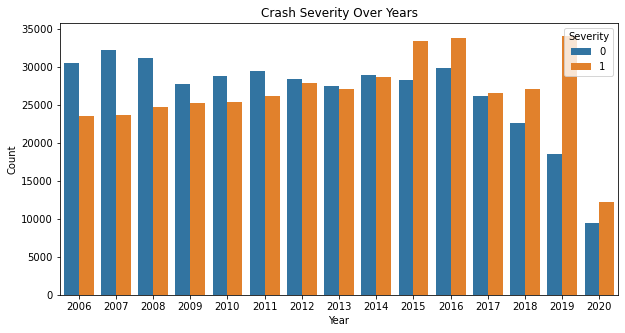

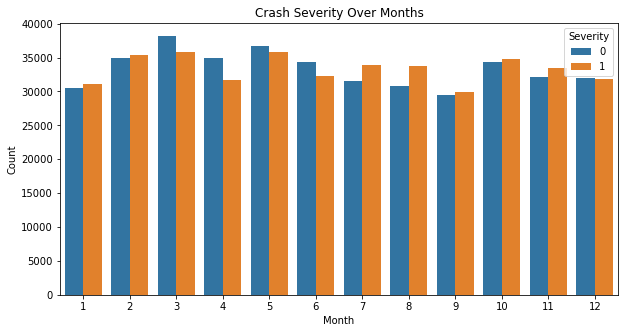

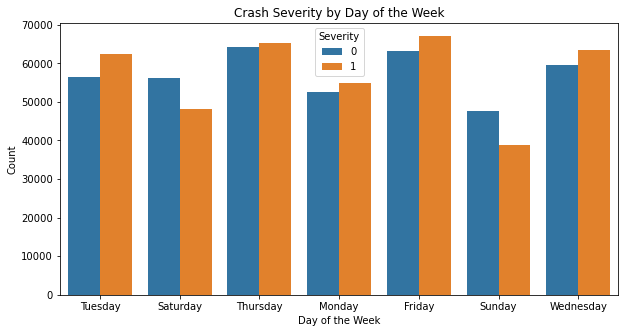

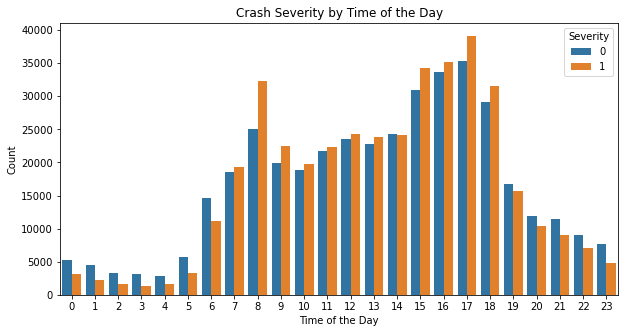

In [17]:
# 3.2 Explore crash information on time features

# Create a count plot using Seaborn for crash severity over years
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='YEAR', hue='SEVERITY')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Crash Severity Over Years')
plt.legend(title='Severity')
plt.show()

# Create a count plot using Seaborn for crash severity over months
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='MONTH', hue='SEVERITY')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Crash Severity Over Months')
plt.legend(title='Severity')
plt.show()

# Create a count plot using Seaborn for crash severity by day of the week
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='Day Week Description', hue='SEVERITY')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Crash Severity by Day of the Week')
plt.legend(title='Severity')
plt.show()

# Create a count plot using Seaborn for crash severity by time of the day
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='HOUR', hue='SEVERITY')
plt.xlabel('Time of the Day')
plt.ylabel('Count')
plt.title('Crash Severity by Time of the Day')
plt.legend(title='Severity')
plt.show()

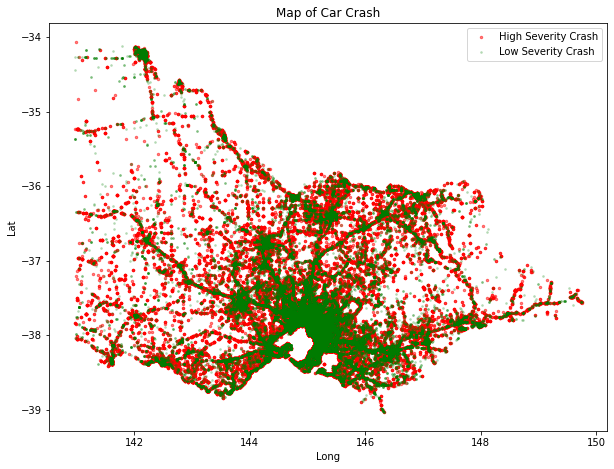

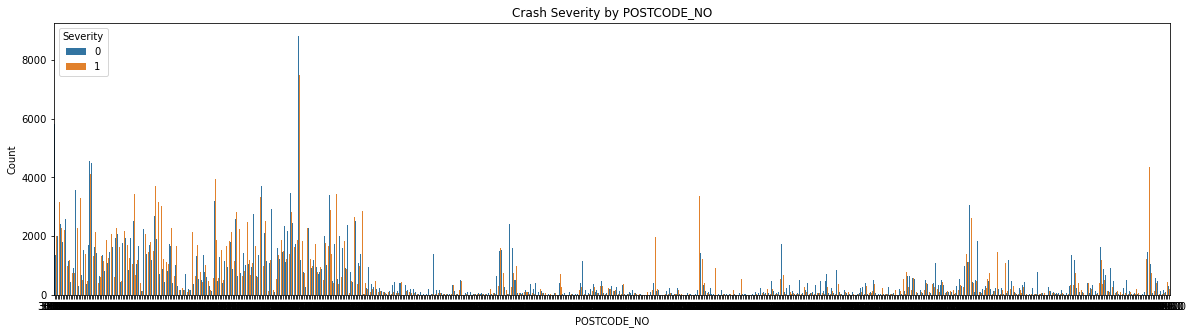

In [18]:
# 3.3 Explore crash information on location features

# Create a map of car crash
plt.figure(figsize=(10, 7.5))
plt.scatter('Long', 'Lat', data=df_rs[df_rs['SEVERITY'] == 0], s=6, c='red', alpha=0.5, label='High Severity Crash')
plt.scatter('Long', 'Lat', data=df_rs[df_rs['SEVERITY'] == 1], s=3, c='green', alpha=0.2, label='Low Severity Crash')
plt.title('Map of Car Crash')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.legend()
plt.show()

# Create a count plot using Seaborn for crash postcode numbers
plt.figure(figsize=(20, 5))
sns.countplot(data=df_rs, x='POSTCODE_NO', hue='SEVERITY')
plt.ylabel('Count')
plt.title('Crash Severity by POSTCODE_NO')
plt.legend(title='Severity')
plt.show()

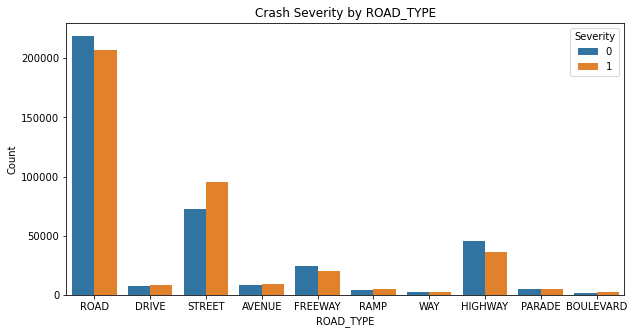

In [19]:
# 3.4 Explore crash information on ROAD_TYPE

# Calculate the frequency of each road type
road_type_counts = df_rs['ROAD_TYPE'].value_counts()
# Select the top 10 most frequent road types
top_road_types = road_type_counts.head(10).index
# Filter the DataFrame to include only the top 10 road types
df_top_road_types = df_rs[df_rs['ROAD_TYPE'].isin(top_road_types)]

# Create a count plot using Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(data=df_top_road_types, x='ROAD_TYPE', hue='SEVERITY')
plt.xlabel('ROAD_TYPE')
plt.ylabel('Count')
plt.title('Crash Severity by ROAD_TYPE')
plt.legend(title='Severity')
plt.show()

# Select the top 6 most frequent road types
top_road_types = road_type_counts.head(6).index
# Keep only rows with road types in the top 6
df_rs = df_rs[df_rs['ROAD_TYPE'].isin(top_road_types)]

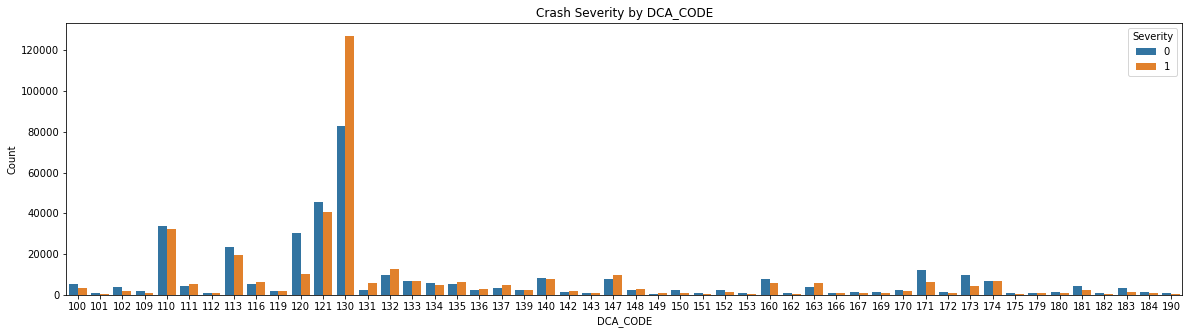

In [20]:
# 3.5 Explore typre of accidents via DCA_CODE

# Calculate the frequency of each road type
dca_code_counts = df_rs['DCA_CODE'].value_counts()
# Select the top 50 most frequent DCA_CODE
top_dca_codes = dca_code_counts.head(50).index
# Filter the DataFrame to include only the top 50 road types
df_top_dca_codes = df_rs[df_rs['DCA_CODE'].isin(top_dca_codes)]

# Create a count plot using Seaborn
plt.figure(figsize=(20, 5))
sns.countplot(data=df_top_dca_codes, x='DCA_CODE', hue='SEVERITY')
plt.xlabel('DCA_CODE')
plt.ylabel('Count')
plt.title('Crash Severity by DCA_CODE')
plt.legend(title='Severity')
plt.show()

# Select the top 40 most frequent accident types
top_dca_codes = dca_code_counts.head(40).index
# Keep only rows with road types in the top 40
df_rs = df_rs[df_rs['DCA_CODE'].isin(top_dca_codes)]

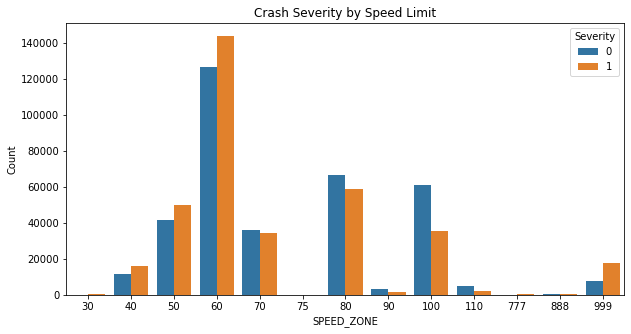

In [21]:
# 3.6 Explore crash information on speed limits

# Create a count plot using Seaborn for crash severity by speed limits
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='SPEED_ZONE', hue='SEVERITY')
plt.xlabel('SPEED_ZONE')
plt.ylabel('Count')
plt.title('Crash Severity by Speed Limit')
plt.legend(title='Severity')
plt.show()

# List of values to drop
values_to_drop = [30, 75, 90, 777, 888]
# Drop rows with specified values in SPEED_ZONE
df_rs = df_rs[~df_rs['SPEED_ZONE'].isin(values_to_drop)]

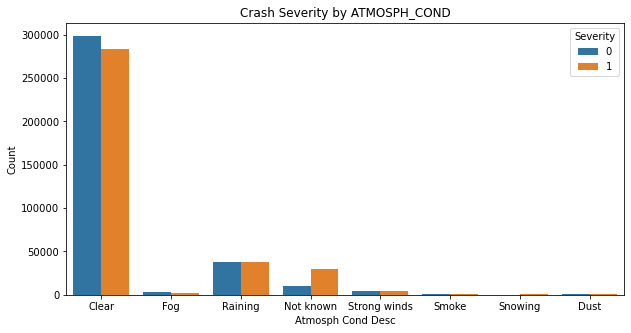

In [22]:
# 3.7 Explore crash information on weather

# Create a count plot using Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='Atmosph Cond Desc', hue='SEVERITY')
plt.xlabel('Atmosph Cond Desc')
plt.ylabel('Count')
plt.title('Crash Severity by ATMOSPH_COND')
plt.legend(title='Severity')
plt.show()

# List of values to drop
values_to_drop = ['Dust', 'Snowing', 'Smoke']
# Drop rows with specified values in ATMOSPH_COND
df_rs = df_rs[~df_rs['Atmosph Cond Desc'].isin(values_to_drop)]

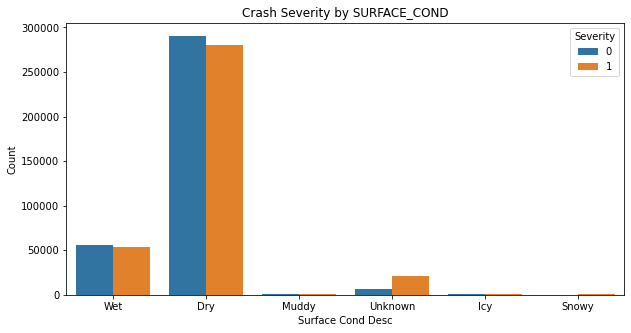

In [23]:
# 3.8 Explore crash information on road surface condition

# Create a count plot using Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='Surface Cond Desc', hue='SEVERITY')
plt.xlabel('Surface Cond Desc')
plt.ylabel('Count')
plt.title('Crash Severity by SURFACE_COND')
plt.legend(title='Severity')
plt.show()

# List of values to drop
values_to_drop = ['Muddy', 'Icy', 'Snowy']
# Drop rows with specified values in ATMOSPH_COND
df_rs = df_rs[~df_rs['Surface Cond Desc'].isin(values_to_drop)]

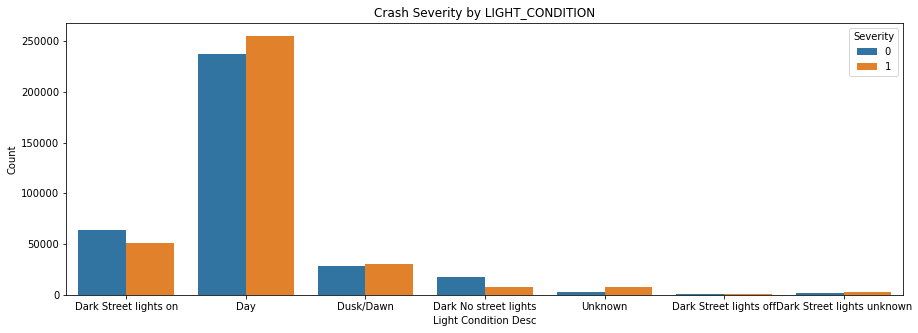

In [24]:
# 3.9 Explore crash information on light condition

# Create a count plot using Seaborn
plt.figure(figsize=(15, 5))
sns.countplot(data=df_rs, x='Light Condition Desc', hue='SEVERITY')
plt.xlabel('Light Condition Desc')
plt.ylabel('Count')
plt.title('Crash Severity by LIGHT_CONDITION')
plt.legend(title='Severity')
plt.show()

# List of values to drop
values_to_drop = ['Dark Street lights unknown', 'Dark Street lights off']
# Drop rows with specified values in ATMOSPH_COND
df_rs = df_rs[~df_rs['Light Condition Desc'].isin(values_to_drop)]

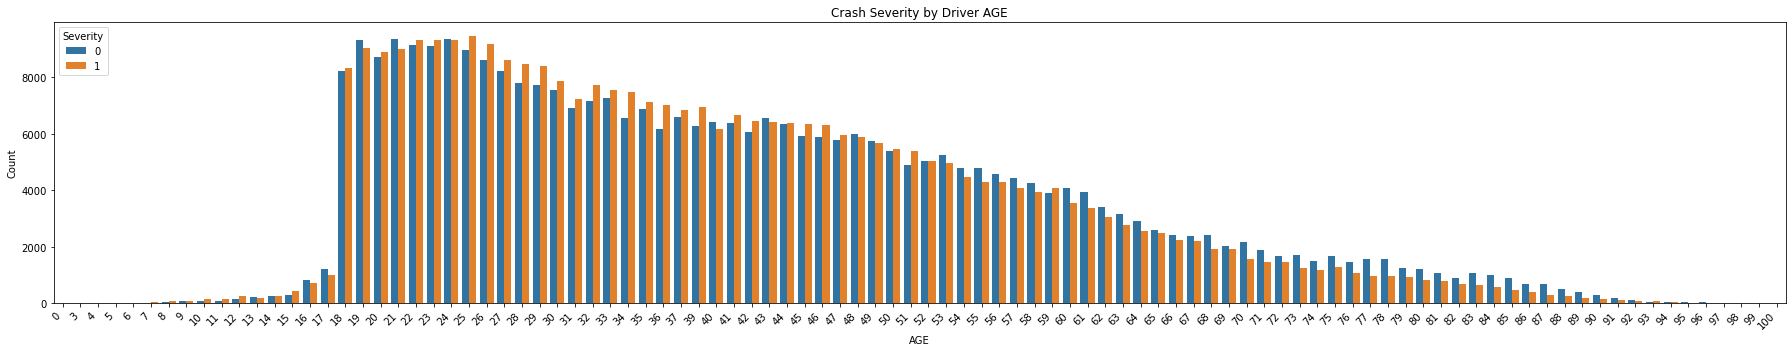

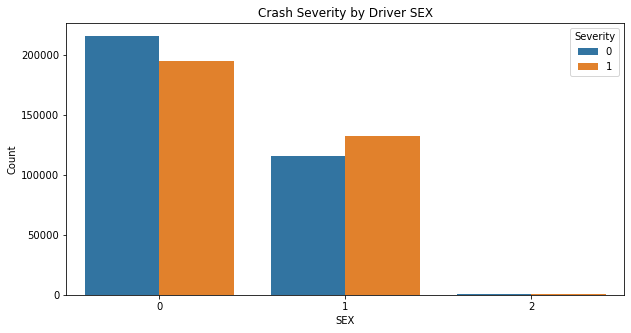

Resampled data: 0    330000
1    330000
Name: SEVERITY, dtype: int64


In [30]:
# 3.10 Explore crash information on Driver

df_rs['AGE'] = df_rs['AGE'].astype(int)  # Convert AGE to int
plt.figure(figsize=(25, 5))
sns.countplot(data=df_rs, x='AGE', hue='SEVERITY')
plt.xlabel('AGE')
plt.ylabel('Count')
plt.title('Crash Severity by Driver AGE')
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels for better visibility
plt.legend(title='Severity')
plt.tight_layout()  # Adjust layout for better visualization
plt.show()

# List of values to drop
values_to_drop = [38]
# Drop rows with specified values in AGE column
df_rs = df_rs[~df_rs['AGE'].isin(values_to_drop)]

# Create a count plot using Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(data=df_rs, x='SEX', hue='SEVERITY')
plt.xlabel('SEX')
plt.ylabel('Count')
plt.title('Crash Severity by Driver SEX')
plt.legend(title='Severity')
plt.show()

# Define the mapping for resampling
mapping = {'M': 0, 'F': 1, 'U': 2}
# Apply the mapping to the SEVERITY column
df_rs['SEX'] = df_rs['SEX'].replace(mapping)

# 3.11 Balancing sample data
df_rs = resample(df_rs, 'SEVERITY', 330000)
print('Resampled data:', df_rs.SEVERITY.value_counts())

Part 4. Model Building and Evaluation

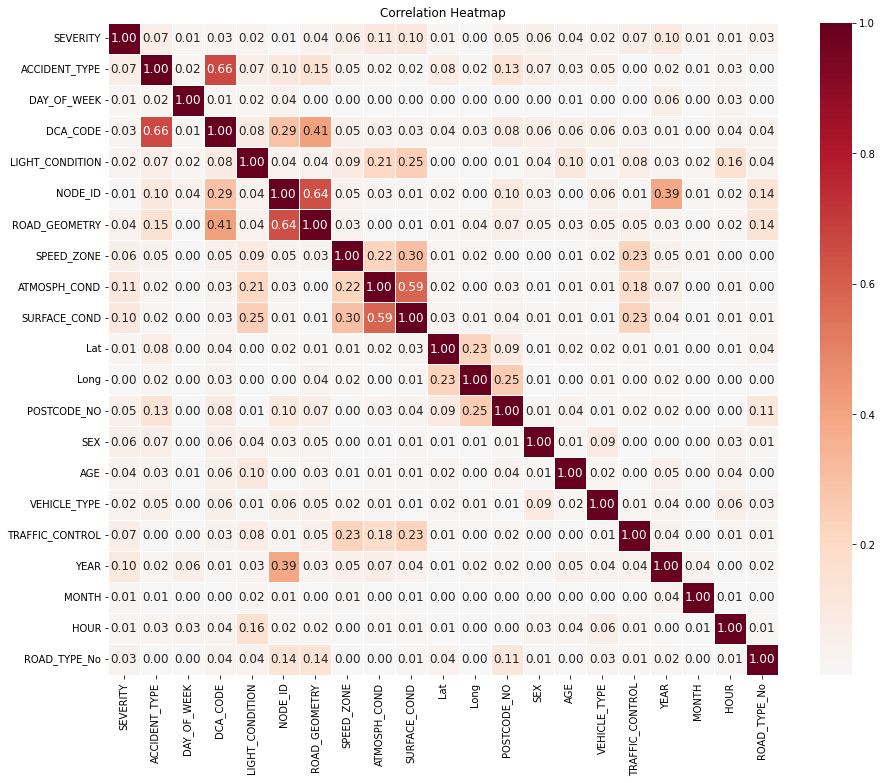

Random Forest Accuracy: 0.9813
Extra Trees Accuracy: 0.9814


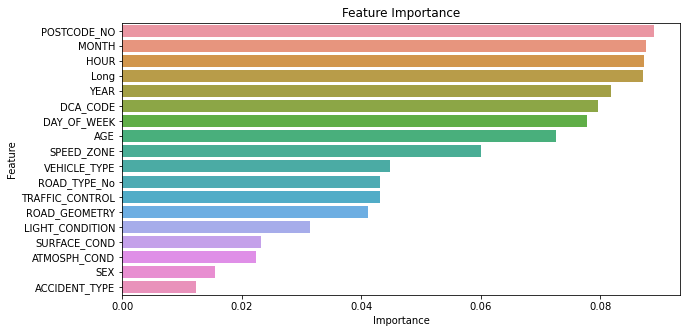

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Reorder the columns to put 'SEVERITY' as the first column
column_order = ['SEVERITY'] + [col for col in df_rs.columns if col != 'SEVERITY']
df_rs = df_rs[column_order]

# Calculate the correlation matrix
correlation_matrix = df_rs.corr()
# Calculate the absolute values of the correlation matrix
abs_correlation_matrix = correlation_matrix.abs()
# Create a heatmap of the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(abs_correlation_matrix, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt='.2f', annot_kws={"size": 12})
plt.title('Correlation Heatmap')
plt.show()

# Identify numerical columns with non-negative minimum values
numerical_columns = df_rs.select_dtypes(include=['number']).columns
numerical_features = df_rs[numerical_columns].columns[df_rs[numerical_columns].min() >= 0]

# Split data into features (X) and target (y)
X = df_rs[numerical_features].drop(columns=['SEVERITY'])
y = df_rs['SEVERITY']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy: {:.4f}".format(accuracy_rf))

# Train and evaluate Extra Trees Classifier
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier.fit(X_train, y_train)
y_pred_et = et_classifier.predict(X_test)
accuracy_et = accuracy_score(y_test, y_pred_et)
print("Extra Trees Accuracy: {:.4f}".format(accuracy_et))

# Get feature importances and plot
feature_importances = et_classifier.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()